In [ ]:
pip install --upgrade pip


In [13]:
print("hi")

hi


In [1]:
import os
from astropy.io import fits
import sunpy.map
#from sunpy.coordinates import NorthOffsetFrame
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import matplotlib.pyplot as plt
import matplotlib.colors
import glob
from scipy import ndimage
import numpy as np
#import sunpy.timeseries
import scipy.ndimage as ndimage
from scipy.ndimage import label
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import ast  
import pandas as pd

/home/vindia/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:

R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/anu/Desktop/samapti/cycle24(feb-july)/april"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/anu/Desktop/samapti/cycle24(feb-july)/april/patch"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for file in fits_files:
    longitude=[]
    longitude_rad=[]
    sinlat=[]
    latitude=[]
    latitude_rad=[]
    coslat=[]
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        data=f[0].data
        data=np.roll(data, -600) 
        nx=data.shape[1]
        ny=data.shape[0]
        #print(f"{nx}  {ny}")
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        for i in range (ny):
            sin_lat= -1+i*(2/ny)
            Latitude_rad= np.arcsin(sin_lat)
            Latitude =Latitude_rad*rtd
            latitude.append(Latitude)
            sinlat.append(sin_lat)
            cos_lat=np.cos(Latitude_rad)
            coslat.append(cos_lat)
            latitude_rad.append(Latitude_rad)
        for j in range(nx):
            Longitude = 0+j*(360/nx)
            Longitude_rad=Longitude*dtr 
            longitude.append(Longitude)
            longitude_rad.append(Longitude_rad)
        Flux=(data)*(R_sun**2)*(d_sinlat)*(dlon_rad)
        #S= (R_sun**2)*(d_sinlat)*(dlon_rad)
        #print(np.nansum(Flux>0))
        #print(np.nansum(Flux<0))
        #print(S)

        
        
        lon=np.array(longitude)
        lat= np.array(latitude)
        Sinlat=np.array( sinlat)
        Coslat=np.array(coslat)
        latrad=np.array(latitude_rad)
        dlat= np.diff(latrad)
        coslat_avg=np.mean([coslat[0:len(coslat)-1],coslat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        print(np.nansum(flux>0))
        print(np.nansum(flux<0))
        #print(s)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)

        
        x,y=np.meshgrid(lon, lat)
        X,Y=np.meshgrid(lon, Sinlat )
     
        
        fluxthres1= 100*(np.mean(s))                         #1.174257520741785e+18
        fluxthres2= -100*(np.mean(s)) 
        #1.174257520741785e+18
        print(fluxthres1)
        print(fluxthres2)
        
       
        
                      
        binary_mask=(flux>fluxthres1)|(flux<fluxthres2)
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(flux,labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        regionthres1 = 2e20
        regionthres2 = -2e20
        binary_mask2=(Totflux>regionthres1)| (Totflux<regionthres2)
        y_indices, x_indices = np.where(binary_mask2==1)

        Lat=lat[y_indices]
        Lon=lon[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        

        sorted_indices1= np.argsort(SH_lon)

        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        #print(M)
        
        
        def model1(lon,p,q1,r1):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)
        Params1, Cov1 = curve_fit(model1,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY1=model1(M, *Params1)
        SQ1=np.subtract(Q,SY1)
        mean1=np.mean(SQ1**2)
        rms1=np.sqrt(mean1)
        Error1=model1(lon, *Params1)+rms1
        Error2=model1(lon, *Params1)-rms1
        
        
        def model2(lon,p,q1,r1,q2,r2):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)
        Params2, Cov2 = curve_fit(model2,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY2=model2(M, *Params2)
        SQ2=np.subtract(Q,SY2)
        mean2=np.mean(SQ2**2)
        rms2=np.sqrt(mean2)
        Error3=model2(lon, *Params2)+rms2
        Error4=model2(lon, *Params2)-rms2
        
        def model3(lon,p,q1,r1,q2,r2,q3,r3):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)
        Params3, Cov3 = curve_fit(model3,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY3=model3(M, *Params3)
        SQ3=np.subtract(Q,SY3)
        mean3=np.mean(SQ3**2)
        rms3=np.sqrt(mean3)
        Error5=model3(lon, *Params3)+rms3
        Error6=model3(lon, *Params3)-rms3
        
        def model4(lon,p,q1,r1,q2,r2,q3,r3,q4,r4):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)+q4*np.sin(4*S+r4)
        Params4, Cov4 = curve_fit(model4,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY4=model4(M, *Params4)
        SQ4=np.subtract(Q,SY4)
        mean4=np.mean(SQ4**2)
        rms4=np.sqrt(mean4)
        Error7=model4(lon, *Params4)+rms4
        Error8=model4(lon, *Params4)-rms4
        
        def model5(lon,p,q1,r1,q2,r2,q3,r3,q4,r4,q5,r5):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)+q4*np.sin(4*S+r4)+q5*np.sin(5*S+r5)
        Params5, Cov5 = curve_fit(model5,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY5=model5(M, *Params5)
        SQ5=np.subtract(Q,SY5)
        mean5=np.mean(SQ5**2)
        rms5=np.sqrt(mean5)
        Error9=model5(lon, *Params5)+rms5
        Error10=model5(lon, *Params5)-rms5
        
        
        
        
        
        
        
        
        
        
        
        
        
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        #print(N)
        def model1(lon,a,b1,c1):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)
        params1, Cov1 = curve_fit(model1,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY1=model1(N, *params1)
        NB1=np.subtract(B,NY1)
        Mean1=np.mean(NB1**2)
        Rms1=np.sqrt(Mean1)
        error1=model1(lon, *params1)+Rms1
        error2=model1(lon, *params1)-Rms1
        
        def model2(lon,a,b1,c1,b2,c2):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)
        params2, Cov2 = curve_fit(model2,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY2=model2(N, *params2)
        NB2=np.subtract(B,NY2)
        Mean2=np.mean(NB2**2)
        Rms2=np.sqrt(Mean2)
        error3=model2(lon, *params2)+Rms2
        error4=model2(lon, *params2)-Rms2
        
        def model3(lon,a,b1,c1,b2,c2,b3,c3):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)
        params3, Cov3 = curve_fit(model3,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY3=model3(N, *params3)
        NB3=np.subtract(B,NY3)
        Mean3=np.mean(NB3**2)
        Rms3=np.sqrt(Mean3)
        error5=model3(lon, *params3)+Rms3
        error6=model3(lon, *params3)-Rms3
        
        def model4(lon,a,b1,c1,b2,c2,b3,c3,b4,c4):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)+b4*np.sin(4*S+c4)
        params4, Cov4 = curve_fit(model4,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY4=model4(N, *params4)
        NB4=np.subtract(B,NY4)
        Mean4=np.mean(NB4**2)
        Rms4=np.sqrt(Mean4)
        error7=model4(lon, *params4)+Rms4
        error8=model4(lon, *params4)-Rms4
        
        def model5(lon,a,b1,c1,b2,c2,b3,c3,b4,c4,b5,c5):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)+b4*np.sin(4*S+c4)+b5*np.sin(5*S+c5)
        params5, Cov5 = curve_fit(model5,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY5=model5(N, *params5)
        NB5=np.subtract(B,NY5)
        Mean5=np.mean(NB5**2)
        Rms5=np.sqrt(Mean5)
        error9=model5(lon, *params5)+Rms5
        error10=model5(lon, *params5)-Rms5
        
        
                
        
        
        
        
        
        
        
        base_name = os.path.basename(file).replace('.fits', '')
        
        
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model1(lon, *Params1), color="Red" ,linewidth=1)
        plt.plot(lon,Error1, color="green",linewidth=1)
        plt.plot(lon,Error2, color="blue",linewidth=1)
       
        plt.plot (lon,model1(lon, *params1), color="Red" ,linewidth=1)
        plt.plot(lon,error1, color="green",linewidth=1)
        plt.plot(lon,error2, color="blue",linewidth=1)
        
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        
        image_name= f" {base_name}_TF1.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model2(lon, *Params2), color="Red" ,linewidth=1)
        plt.plot(lon,Error3, color="green",linewidth=1)
        plt.plot(lon,Error4, color="blue",linewidth=1)
        
        plt.plot (lon,model2(lon, *params2), color="Red" ,linewidth=1)
        plt.plot(lon,error3, color="green",linewidth=1)
        plt.plot(lon,error4, color="blue",linewidth=1)
       
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF2.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model3(lon, *Params3), color="Red" ,linewidth=1)
        plt.plot(lon,Error5, color="green",linewidth=1)
        plt.plot(lon,Error6, color="blue",linewidth=1)
        
        plt.plot (lon,model3(lon, *params3), color="Red" ,linewidth=1)
        plt.plot(lon,error5, color="green",linewidth=1)
        plt.plot(lon,error6, color="blue",linewidth=1)
      
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF3.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #plt.gca().set_aspect("equal")
        #ax.grid(True)
        Output=[]
        for lamda in range(0,360,30):
            for phi in range(-90,90,20):
                ax.add_patch( Rectangle((lamda,phi),30, 20,fc ='none', ec ='none') )
        #ax.add_patch( Rectangle((0,-90),
                        #20, 20,
                        #fc ='none', 
                        #ec ='w',
                phi1, phi2= phi, phi+5
                lamda1, lamda2=lamda, lamda+5
                mask= (x>=lamda1)&(x<lamda2)&(y>=phi1)&(y<phi2)
                flux_values=flux[mask]
                #print(flux_values)
                totflux_values=np.sum(np.abs(flux_values))
                #print(np.abs(totflux_values))
                if (totflux_values>=2e20):
                    print(1)
                else:
                    print(0)
                    
           
        phi1, phi2= -30, -10
        lamda1, lamda2=210, 240
        mask= (x>=lamda1)&(x<lamda2)&(y>=phi1)&(y<phi2)
        flux_values=flux[mask]
        print(flux_values)
        totflux_values=np.sum(flux_values)
        print(np.abs(totflux_values))
        if (np.abs(totflux_values)>=2e20):
            print(1)
        else:
            print(0)
                            

             

        
        plt.plot (lon,model4(lon, *Params4), color="Red" ,linewidth=1)
        plt.plot(lon,Error7, color="green",linewidth=1)
        plt.plot(lon,Error8, color="blue",linewidth=1)
       
        plt.plot (lon,model4(lon, *params4), color="Red" ,linewidth=1)
        plt.plot(lon,error7, color="green",linewidth=1)
        plt.plot(lon,error8, color="blue",linewidth=1)
       
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF4.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        #plt.close(fig)
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray',vmin=-100 , vmax=100)
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model5(lon, *Params5), color="Red" ,linewidth=1)
        plt.plot(lon,Error9, color="green",linewidth=1)
        plt.plot(lon,Error10, color="blue",linewidth=1)
        
        
        plt.plot (lon,model5(lon, *params5), color="Red" ,linewidth=1)
        plt.plot(lon,error9, color="green",linewidth=1)
        plt.plot(lon,error10, color="blue",linewidth=1)
       
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF5.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        #plt.savefig(mag_image, dpi=300)
        plt.close(fig)







FileNotFoundError: [Errno 2] No such file or directory: '/home/anu/Desktop/samapti/cycle24(feb-july)/april'

In [15]:
print("hi")

hi


In [ ]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/vindia/samapti/cycle24(feb-july)/CR2149/tip_difference(TF1)"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for file in fits_files:
    longitude=[]
    longitude_rad=[]
    sinlat=[]
    latitude=[]
    latitude_rad=[]
    coslat=[]
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        data=f[0].data
        data=np.roll(data, -4110) 
        nx=data.shape[1]
        ny=data.shape[0]
        #print(f"{nx}  {ny}")
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        for i in range (ny):
            sin_lat= -1+i*(2/ny)
            Latitude_rad= np.arcsin(sin_lat)
            Latitude =Latitude_rad*rtd
            latitude.append(Latitude)
            sinlat.append(sin_lat)
            cos_lat=np.cos(Latitude_rad)
            coslat.append(cos_lat)
            latitude_rad.append(Latitude_rad)
        for j in range(nx):
            Longitude = 0+j*(360/nx)
            Longitude_rad=Longitude*dtr 
            longitude.append(Longitude)
            longitude_rad.append(Longitude_rad)
        Flux=(data)*(R_sun**2)*(d_sinlat)*(dlon_rad)
        #S= (R_sun**2)*(d_sinlat)*(dlon_rad)
        #print(np.nansum(Flux>0))
        #print(np.nansum(Flux<0))
        #print(S)

        
        
        lon=np.array(longitude)
        lat= np.array(latitude)
        Sinlat=np.array( sinlat)
        Coslat=np.array(coslat)
        latrad=np.array(latitude_rad)
        dlat= np.diff(latrad)
        coslat_avg=np.mean([coslat[0:len(coslat)-1],coslat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        print(np.nansum(flux>0))
        print(np.nansum(flux<0))
        #print(s)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)

        
        x,y=np.meshgrid(lon, lat)
        X,Y=np.meshgrid(lon, Sinlat )
     
        
        fluxthres1= 100*(np.mean(s))                         #1.174257520741785e+18
        fluxthres2= -100*(np.mean(s)) 
        #1.174257520741785e+18
        print(fluxthres1)
        print(fluxthres2)
        
       
        
                      
        binary_mask=(flux>fluxthres1)|(flux<fluxthres2)
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(np.abs(flux),labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        regionthres1 = 2e20
        regionthres2 = -2e20
        binary_mask2=(Totflux>regionthres1)| (Totflux<regionthres2)
        y_indices, x_indices = np.where(binary_mask2==1)

        Lat=lat[y_indices]
        Lon=lon[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        

        sorted_indices1= np.argsort(SH_lon)

        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        #print(M)
        
        
        def model1(lon,p,q1,r1):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)
        Params1, Cov1 = curve_fit(model1,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY1=model1(M, *Params1)
        SQ1=np.subtract(Q,SY1)
        mean1=np.mean(SQ1**2)
        rms1=np.sqrt(mean1)
        Error1=model1(lon, *Params1)+rms1
        Error2=model1(lon, *Params1)-rms1
        
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        #print(N)
        def model1(lon,a,b1,c1):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)
        params1, Cov1 = curve_fit(model1,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY1=model1(N, *params1)
        NB1=np.subtract(B,NY1)
        Mean1=np.mean(NB1**2)
        Rms1=np.sqrt(Mean1)
        error1=model1(lon, *params1)+Rms1
        error2=model1(lon, *params1)-Rms1
        
        base_name = os.path.basename(file).replace('.fits', '')
        
        tip_difference=np.subtract(model1(lon, *params1),model1(lon, *Params1))
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,binary_mask2, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model1(lon, *Params1), color="Red" ,linewidth=1)
        plt.plot(lon,Error1, color="green",linewidth=1)
        plt.plot(lon,Error2, color="blue",linewidth=1)
       
        plt.plot (lon,model1(lon, *params1), color="Red" ,linewidth=1)
        plt.plot(lon,error1, color="green",linewidth=1)
        plt.plot(lon,error2, color="blue",linewidth=1)
        plt.plot(lon,tip_difference)
        
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        
        image_name= f" {base_name}_TF1.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        

In [ ]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/vindia/samapti/cycle24(feb-july)/CR2149/tip_difference(TF2)"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for file in fits_files:
    longitude=[]
    longitude_rad=[]
    sinlat=[]
    latitude=[]
    latitude_rad=[]
    coslat=[]
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        data=f[0].data
        data=np.roll(data, -4110) 
        nx=data.shape[1]
        ny=data.shape[0]
        #print(f"{nx}  {ny}")
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        for i in range (ny):
            sin_lat= -1+i*(2/ny)
            Latitude_rad= np.arcsin(sin_lat)
            Latitude =Latitude_rad*rtd
            latitude.append(Latitude)
            sinlat.append(sin_lat)
            cos_lat=np.cos(Latitude_rad)
            coslat.append(cos_lat)
            latitude_rad.append(Latitude_rad)
        for j in range(nx):
            Longitude = 0+j*(360/nx)
            Longitude_rad=Longitude*dtr 
            longitude.append(Longitude)
            longitude_rad.append(Longitude_rad)
        Flux=(data)*(R_sun**2)*(d_sinlat)*(dlon_rad)
        #S= (R_sun**2)*(d_sinlat)*(dlon_rad)
        #print(np.nansum(Flux>0))
        #print(np.nansum(Flux<0))
        #print(S)

        
        
        lon=np.array(longitude)
        lat= np.array(latitude)
        Sinlat=np.array( sinlat)
        Coslat=np.array(coslat)
        latrad=np.array(latitude_rad)
        dlat= np.diff(latrad)
        coslat_avg=np.mean([coslat[0:len(coslat)-1],coslat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        print(np.nansum(flux>0))
        print(np.nansum(flux<0))
        #print(s)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)

        
        x,y=np.meshgrid(lon, lat)
        X,Y=np.meshgrid(lon, Sinlat )
     
        
        fluxthres1= 100*(np.mean(s))                         #1.174257520741785e+18
        fluxthres2= -100*(np.mean(s)) 
        #1.174257520741785e+18
        print(fluxthres1)
        print(fluxthres2)
        
       
        
                      
        binary_mask=(flux>fluxthres1)|(flux<fluxthres2)
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(np.abs(flux),labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        regionthres1 = 2e20
        regionthres2 = -2e20
        binary_mask2=(Totflux>regionthres1)| (Totflux<regionthres2)
        y_indices, x_indices = np.where(binary_mask2==1)

        Lat=lat[y_indices]
        Lon=lon[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        

        sorted_indices1= np.argsort(SH_lon)

        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        #print(M)
        
        def model2(lon,p,q1,r1,q2,r2):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)
        Params2, Cov2 = curve_fit(model2,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY2=model2(M, *Params2)
        SQ2=np.subtract(Q,SY2)
        mean2=np.mean(SQ2**2)
        rms2=np.sqrt(mean2)
        Error3=model2(lon, *Params2)+rms2
        Error4=model2(lon, *Params2)-rms2
        
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        #print(N)
        
        def model2(lon,a,b1,c1,b2,c2):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)
        params2, Cov2 = curve_fit(model2,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY2=model2(N, *params2)
        NB2=np.subtract(B,NY2)
        Mean2=np.mean(NB2**2)
        Rms2=np.sqrt(Mean2)
        error3=model2(lon, *params2)+Rms2
        error4=model2(lon, *params2)-Rms2
        tip_difference=np.subtract(model2(lon, *params2),model2(lon, *Params2))
        
        base_name = os.path.basename(file).replace('.fits', '')
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,binary_mask2, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model2(lon, *Params2), color="Red" ,linewidth=1)
        plt.plot(lon,Error3, color="green",linewidth=1)
        plt.plot(lon,Error4, color="blue",linewidth=1)
        
        plt.plot (lon,model2(lon, *params2), color="Red" ,linewidth=1)
        plt.plot(lon,error3, color="green",linewidth=1)
        plt.plot(lon,error4, color="blue",linewidth=1)
        plt.plot(lon,tip_difference)
       
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF2.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)

['/home/vindia/samapti/cycle24(feb-july)/CR2149/hmi.mrdailysynframe_720s.20140407_120000_TAI.data.fits']


NameError: name 'base_name' is not defined

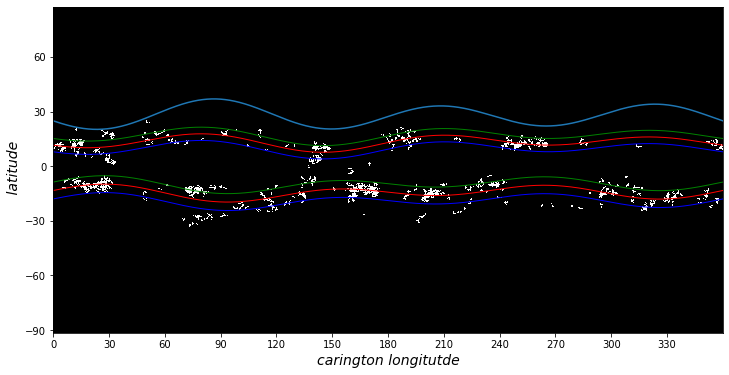

In [34]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/RFT2e21"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for i, file in enumerate (fits_files):
    
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        #T=header.get("T_OBS")
        data=f[0].data
        data=np.roll(data, -600) 
        nx=data.shape[1]
        ny=data.shape[0]
        i=np.arange(ny)
        j=np.arange(nx)
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        sin_lat = -1 + i * d_sinlat
        lat_rad = np.arcsin(sin_lat)
        lat_deg = lat_rad * rtd
        cos_lat = np.cos(lat_rad)
        lon_deg=0+j*(360/nx)
        lon_rad=lon_deg*dtr
        dlat= np.diff(lat_rad)
        coslat_avg=np.mean([cos_lat[0:len(cos_lat)-1],cos_lat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)
        x,y=np.meshgrid( lon_deg, lat_deg)
        fluxthres= 50*(np.mean(s))
        regionfluxthres = 2e20
        binary_mask=np.abs(flux)>=fluxthres
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(np.abs(flux),labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        binary_mask2=np.abs(Totflux)>= regionfluxthres
        y_indices, x_indices = np.where(binary_mask2==1)
        Lat=lat_deg[y_indices]
        Lon=lon_deg[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        sorted_indices1= np.argsort(SH_lon)
        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        
        def model3(lon_deg,p,q1,r1,q2,r2,q3,r3):
            S= lon_deg*dtr
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)
        Params3, Cov3 = curve_fit(model3,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY3=model3(M, *Params3)
        SQ3=np.subtract(Q,SY3)
        mean3=np.mean(SQ3**2)
        rms3=np.sqrt(mean3)
        Error5=model3(lon_deg, *Params3)+rms3
        Error6=model3(lon_deg, *Params3)-rms3
        
        def model3(lon_deg,a,b1,c1,b2,c2,b3,c3):
            S= lon_deg*dtr
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)
        params3, Cov3 = curve_fit(model3,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY3=model3(N, *params3)
        NB3=np.subtract(B,NY3)
        Mean3=np.mean(NB3**2)
        Rms3=np.sqrt(Mean3)
        error5=model3(lon_deg, *params3)+Rms3
        error6=model3(lon_deg, *params3)-Rms3
        tip_difference=np.subtract(model3(lon_deg, *params3),model3(lon_deg, *Params3))
        

        
        
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,binary_mask2, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
       
        
        plt.plot (lon_deg,model3(lon_deg, *Params3), color="Red" ,linewidth=1)
        plt.plot(lon_deg,Error5, color="green",linewidth=1)
        plt.plot(lon_deg,Error6, color="blue",linewidth=1)
        
        plt.plot (lon_deg,model3(lon_deg, *params3), color="Red" ,linewidth=1)
        plt.plot(lon_deg,error5, color="green",linewidth=1)
        plt.plot(lon_deg,error6, color="blue",linewidth=1)
        plt.plot(lon_deg,tip_difference)
        #plt.plot(lon,tip_difference2)
        #plt.plot(lon,abs_tip_difference2,color="red")
        

      
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF3.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        
        
        #fig = plt.figure(figsize=(12,6))
        #plt.plot(lon,tip_difference2)
        #fig = plt.figure(figsize=(12,6))
        #plt.plot(lon,abstip_difference,color="pink")
        
        

In [ ]:
        ax.add_patch( Rectangle((0,-90),
                        20, 20,
                        fc ='none', 
                        ec ='w',))

In [ ]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/anu/Desktop/samapti/cycle24(feb-july)/april/patch"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for file in fits_files:
    longitude=[]
    longitude_rad=[]
    sinlat=[]
    latitude=[]
    latitude_rad=[]
    coslat=[]
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        data=f[0].data
        data=np.roll(data, -600) 
        nx=data.shape[1]
        ny=data.shape[0]
        
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        for i in range (ny):                        #can make array of ny and nx then can do it 
            sin_lat= -1+i*(2/ny)                    # optimize  the loop
            Latitude_rad= np.arcsin(sin_lat)
            Latitude =Latitude_rad*rtd
            latitude.append(Latitude)
            sinlat.append(sin_lat)
            cos_lat=np.cos(Latitude_rad)
            coslat.append(cos_lat)
            latitude_rad.append(Latitude_rad)
        for j in range(nx):
            Longitude = 0+j*(360/nx)
            Longitude_rad=Longitude*dtr 
            longitude.append(Longitude)
            longitude_rad.append(Longitude_rad)
            
        lon=np.array(longitude)
        lat= np.array(latitude)
        Sinlat=np.array( sinlat)
        Coslat=np.array(coslat)
        latrad=np.array(latitude_rad)
        dlat= np.diff(latrad)
        coslat_avg=np.mean([coslat[0:len(coslat)-1],coslat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        #print(np.nansum(flux>0))
        #print(np.nansum(flux<0))
        #print(s)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)
        x,y=np.meshgrid(lon, lat)
        fluxthres= 100*(np.mean(s))                         #1.174257520741785e+18
        
        regionthres = 2e20
        
        binary_mask=np.abs(flux)>=fluxthres
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(np.abs(flux),labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        
        
        
        

        output1=[]
        output2=[]
        
        for lamda in range(0,30):
            for phi in range(10,30):
                phi1, phi2= phi, phi+10
                lamda1, lamda2=lamda, lamda+15
                mask= (x>=lamda1)&(x<lamda2)&(y>=phi1)&(y<phi2)
                fluxvalue=np.where(mask,flux,0)                                                             #np.where(mask, flux,0)
                binary_mask=(np.abs(fluxvalue)>=fluxthres)
                labeled_array, num_features = label(binary_mask)
                totflux=ndimage.sum(np.abs(fluxvalue),labeled_array, range(1, num_features + 1))
                Totflux= np.zeros_like(fluxvalue)
                for i, val in enumerate(totflux):
                    Totflux[labeled_array == (i + 1)] = val
                
                for i in range (Totflux.shape[0]):
                    for j in range(Totflux.shape[1]):
                        if np.abs(Totflux[i,j])>=regionthres:
                            
                            
                            output1.append([phi1, lamda1, 1])
                        else: 
                            output2.append(0)
                    
                        
                   
                        
        
        print("hi")
                
                #print(binary_mask2.shape)
                #y_indices, x_indices = np.where(binary_mask2==1)
                
 

 #output2 = np.column_stack((NHlon_sorted, NHlat_sorted))               


# Active region

In [341]:
print(1250+130)

1380


In [342]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/anu/Desktop/samapti/cycle24(feb-july)/april/patch"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for i, file in enumerate (fits_files):
    
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        #T=header.get("T_OBS")
        data=f[0].data
        data=np.roll(data, -1380) 
        nx=data.shape[1]
        ny=data.shape[0]
        i=np.arange(ny)
        j=np.arange(nx)
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        sin_lat = -1 + i * d_sinlat
        lat_rad = np.arcsin(sin_lat)
        lat_deg = lat_rad * rtd
        cos_lat = np.cos(lat_rad)
        lon_deg=0+j*(360/nx)
        lon_rad=lon_deg*dtr
        dlat= np.diff(lat_rad)
        coslat_avg=np.mean([cos_lat[0:len(cos_lat)-1],cos_lat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)
        x,y=np.meshgrid( lon_deg, lat_deg)
        fluxthres= 100*(np.mean(s))
        regionfluxthres = 2e20
        binary_mask=np.abs(flux)>=fluxthres
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(np.abs(flux),labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        binary_mask2=np.abs(Totflux)>= regionfluxthres
        y_indices, x_indices = np.where(binary_mask2==1)
        Lat=lat_deg[y_indices]
        Lon=lon_deg[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        sorted_indices1= np.argsort(SH_lon)
        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        
        def model3(lon_deg,p,q1,r1,q2,r2,q3,r3):
            S= lon_deg*dtr
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)
        Params3, Cov3 = curve_fit(model3,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY3=model3(M, *Params3)
        SQ3=np.subtract(Q,SY3)
        mean3=np.mean(SQ3**2)
        rms3=np.sqrt(mean3)
        Error5=model3(lon_deg, *Params3)+rms3
        Error6=model3(lon_deg, *Params3)-rms3
        
        def model3(lon_deg,a,b1,c1,b2,c2,b3,c3):
            S= lon_deg*dtr
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)
        params3, Cov3 = curve_fit(model3,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY3=model3(N, *params3)
        NB3=np.subtract(B,NY3)
        Mean3=np.mean(NB3**2)
        Rms3=np.sqrt(Mean3)
        error5=model3(lon_deg, *params3)+Rms3
        error6=model3(lon_deg, *params3)-Rms3
        tip_difference=np.subtract(model3(lon_deg, *params3),model3(lon_deg, *Params3))
        

        
        output=[]
       
        patch_id=1
        
        for lamda in range(0,360,2):
            for phi in range(-45,45,2):
                lamda1, lamda2=lamda, lamda+5
                
                phi1, phi2=phi, phi+10
                
                mask= (lon_deg>=lamda1)&(lon_deg<lamda2)
                TD=tip_difference[mask]
                meantd=np.mean(TD)
                maxtd=np.max(TD)
                mintd=np.min(TD)
                output.append([patch_id, meantd, maxtd, mintd])
                
                patch_id += 1
                

with open ("output1.txt","w") as input:
    for value in output:
        input.write(f"{value}\n")              

['/home/vindia/samapti/cycle24(feb-july)/CR2149/hmi.mrdailysynframe_720s.20140413_120000_TAI.data.fits']


In [373]:
print(2160+130)



               

2290


In [374]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/anu/Desktop/samapti/cycle24(feb-july)/april/patch"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for i, file in enumerate (fits_files):
    
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        #T=header.get("T_OBS")
        data=f[0].data
        data=np.roll(data, -2290) 
        nx=data.shape[1]
        ny=data.shape[0]
        i=np.arange(ny)
        j=np.arange(nx)
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        sin_lat = -1 + i * d_sinlat
        lat_rad = np.arcsin(sin_lat)
        lat_deg = lat_rad * rtd
        cos_lat = np.cos(lat_rad)
        lon_deg=0+j*(360/nx)
        lon_rad=lon_deg*dtr
        dlat= np.diff(lat_rad)
        coslat_avg=np.mean([cos_lat[0:len(cos_lat)-1],cos_lat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)
        x,y=np.meshgrid( lon_deg, lat_deg)
        fluxthres= 100*(np.mean(s))
        regionthres = 2e20
        binary_mask=np.abs(flux)>=fluxthres
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(np.abs(flux),labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        
        
       
        output=[]
       
        patch_id=1
        
        for lamda in range(0,360,2):
            for phi in range(-45,45,2):
                lamda1, lamda2=lamda, lamda+5
                Lamda=0.5*(lamda1+lamda2)
                phi1, phi2=phi, phi+10
                Phi=0.5*(phi1+phi2)
                mask= (x>=lamda1)&(x<lamda2)&(y>=phi1)&(y<phi2)
                TFlux=np.sum((Totflux[mask]))                         
                maxTotflux=np.max((Totflux[mask]))
                minTotflux=np.min(Totflux[mask])
                #print(minTotflux)
                meanTotflux=np.mean(Totflux[mask])
                if np.any(Totflux[mask] >= regionthres):
                    #print(maxTotflux)
                    output.append([patch_id, Lamda, Phi, TFlux,maxTotflux, minTotflux, meanTotflux,1])
                else:
                    output.append([patch_id, Lamda, Phi,TFlux,maxTotflux, minTotflux, meanTotflux, 0])

                patch_id += 1

              

with open ("output2.txt","w") as input:
    for value in output:
        input.write(f"{value}\n")

['/home/vindia/samapti/cycle24(feb-july)/CR2149/hmi.mrdailysynframe_720s.20140420_120000_TAI.data.fits']


In [375]:

file1 = "output1.txt"
file2 = "output2.txt"
output_file = "CR6day7.txt"

with open(file1) as f1, open(file2) as f2, open(output_file, "w") as fout:
    for l1, l2 in zip(f1, f2):
        part1 = ast.literal_eval(l1.strip())
        part2 = ast.literal_eval(l2.strip())
        fout.write(str(part1 + part2[1:]) + "\n")


In [382]:
file1 = "CR6day0.txt"
file2 = "CR6day7.txt"
output_file="CR6Day7.txt"
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/CR6_45"
T = 7
output_path= os.path.join(folder_path, output_file)
with open(file1) as f1, open(file2) as f2, open(output_path, "w") as fout:
    for l1, l2 in zip(f1, f2):
        p1 = ast.literal_eval(l1.strip())
        p2 = ast.literal_eval(l2.strip())

        if p1[-1]==0 and p1[-1] != p2[-1]: 
            fout.write(f"{[p1[0], p1[1], p1[2], p1[3],p1[4],p1[5],T,p2[6],p2[7],p2[9], 1]}\n")
        else:
            fout.write(f"{[p1[0], p1[1], p1[2], p1[3],p1[4],p1[5],T,p2[6],p2[7],p2[9], 0]}\n")
            



In [383]:

output_file="CR6_45.txt"
folder_path1 = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45"
output_path= os.path.join(folder_path1, output_file)

def load_list_from_file(filename):
    with open(filename, "r") as f:
        return [ast.literal_eval(line.strip()) for line in f]

folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/CR6_45"
txt_files = sorted(glob.glob(os.path.join(folder_path, "*.txt")))

base_file = txt_files[0]
file_data = load_list_from_file(base_file)


existing_first_values = {lst[0] for lst in file_data}


for filename in txt_files[1:]:
    other_data = load_list_from_file(filename)
    for lst in other_data:
        if lst[0] not in existing_first_values:
            file_data.append(lst)
            existing_first_values.add(lst[0])


with open(output_path, "w") as f:
    for lst in file_data:
        f.write(f"{lst}\n")




100 is change to 300

# Flare

In [386]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
#csv_path="/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/xrt_flarecat.csv"
#df = pd.read_csv(csv_path)
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for i, file in enumerate (fits_files):
    
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        #T=header.get("T_OBS")
        data=f[0].data
        data=np.roll(data, -1250) 
        nx=data.shape[1]
        ny=data.shape[0]
        i=np.arange(ny)
        j=np.arange(nx)
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        sin_lat = -1 + i * d_sinlat
        lat_rad = np.arcsin(sin_lat)
        lat_deg = lat_rad * rtd
        cos_lat = np.cos(lat_rad)
        lon_deg=0+j*(360/nx)
        lon_rad=lon_deg*dtr
        dlat= np.diff(lat_rad)
        coslat_avg=np.mean([cos_lat[0:len(cos_lat)-1],cos_lat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)
        x,y=np.meshgrid( lon_deg, lat_deg)
        fluxthres= 100*(np.mean(s))
        regionthres = 2e20
        binary_mask=np.abs(flux)>=fluxthres
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(np.abs(flux),labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        binary_mask2=np.abs(Totflux)>=regionthres
        y_indices, x_indices = np.where(binary_mask2==1)
        Lat=lat_deg[y_indices]
        Lon=lon_deg[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        sorted_indices1= np.argsort(SH_lon)
        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        
        def model3(lon_deg,p,q1,r1,q2,r2,q3,r3):
            S= lon_deg*dtr
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)
        Params3, Cov3 = curve_fit(model3,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY3=model3(M, *Params3)
        SQ3=np.subtract(Q,SY3)
        mean3=np.mean(SQ3**2)
        rms3=np.sqrt(mean3)
        Error5=model3(lon_deg, *Params3)+rms3
        Error6=model3(lon_deg, *Params3)-rms3
        
        def model3(lon_deg,a,b1,c1,b2,c2,b3,c3):
            S= lon_deg*dtr
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)
        params3, Cov3 = curve_fit(model3,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY3=model3(N, *params3)
        NB3=np.subtract(B,NY3)
        Mean3=np.mean(NB3**2)
        Rms3=np.sqrt(Mean3)
        error5=model3(lon_deg, *params3)+Rms3
        error6=model3(lon_deg, *params3)-Rms3
        phi=-17
        Lamda=226.18415396
        tip_difference=np.subtract(model3(Lamda, *params3),model3(Lamda, *Params3))
        print(tip_difference)
        

         
       

['/home/vindia/samapti/cycle24(feb-july)/CR2149/hmi.mrdailysynframe_720s.20140412_120000_TAI.data.fits']
18.169419474075124


In [337]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(-11*u.deg, -9*u.deg,
               frame=frames.HeliographicStonyhurst,
               observer="earth",
               obstime="2014-04-20T04:27:00")


cr = hpc.transform_to(frames.HeliographicCarrington)    #236.65181926, 225.90443565
print(cr)
#1.96402257


<SkyCoord (HeliographicCarrington: obstime=2014-04-20T04:27:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, )
    (179.62572105, -9., 1.)>


In [130]:
print(1250-130) #11
print(1380-130) #12
print(1380+130) #14
print(1510+130) #15
print(1640+130) #16
print(1770+130) #17
print(1900+130) #18
print(2030+130) #19
print(2160+130) #20
print(2290+130) #21
print(2420+130) #22
print(2550+130) #23
print(2680+130) #24
print(2810+130) #25
print(2940+130) #26
print(3070+130) #27
print(3200+130) #28
print(3330+130) #29
print(3460+130) #30
print(3590+130) #01
print(3720+130) #02
print(3850+130) #03
print(3980+130) #04

1120
1250
1510
1640
1770
1900
2030
2160
2290
2420
2550
2680
2810
2940
3070
3200
3330
3460
3590
3720
3850
3980
4110


In [132]:
print(27*130)
print(3510+600)

3510
4110


In [351]:


R_sun = 6.96e10
dtr, rtd = np.pi/180, 180/np.pi

csv_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/xrt_flarecat.csv"
df = pd.read_csv(csv_path)

folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))


def model3(lon_deg,a,b1,c1,b2,c2,b3,c3):
    S = lon_deg*dtr
    return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)

def fit_and_rms(lon, lat):
    params, _ = curve_fit(model3, lon, lat, method='trf')
    fit = model3(lon, *params)
    rms = np.sqrt(np.mean((lat - fit)**2))
    return params, rms

for file in fits_files:
    print(fits_files)
    with fits.open(file) as f:
        data = np.roll(f[0].data, -1380)

    ny, nx = data.shape
    i, j = np.arange(ny), np.arange(nx)
    lat_rad = np.arcsin(-1 + i * (2/ny))
    lat_deg = lat_rad * rtd
    lon_deg = j * (360/nx)
    cos_lat = np.cos(lat_rad)
    dlon_rad = (360/nx)*dtr

    dlat = np.diff(lat_rad)
    coslat_avg = np.mean([cos_lat[:-1], cos_lat[1:]], axis=0)
    s = (R_sun**2) * coslat_avg * dlat * dlon_rad
    flux = data[:-1] * s[:,None]

    flux = np.insert(flux, 1079, np.nan, axis=0)
    fluxthres = 100*np.mean(s)
    regionthres = 2e20

    labeled_array, num_features = label(np.abs(flux) >= fluxthres)
    totflux = ndimage.sum(np.abs(flux), labeled_array, range(1, num_features+1))

    Totflux = np.zeros_like(flux)
    for n, val in enumerate(totflux):
        Totflux[labeled_array == n+1] = val

    y_indices, x_indices = np.where(np.abs(Totflux) >= regionthres)
    Lat, Lon = lat_deg[y_indices], lon_deg[x_indices]

   
    SH_lat, SH_lon = Lat[Lat<0], Lon[Lat<0]
    NH_lat, NH_lon = Lat[Lat>=0], Lon[Lat>=0]

   
    M, Q = np.sort(SH_lon), SH_lat[np.argsort(SH_lon)]
    N, B = np.sort(NH_lon), NH_lat[np.argsort(NH_lon)]

    Params3, rms_s = fit_and_rms(M, Q)
    params3, rms_n = fit_and_rms(N, B)

    
    Lamda =179.62572105
    tip_difference=np.subtract(model3(Lamda, *params3),model3(Lamda, *Params3))

   # print(tip_difference)
    df.loc[15538, "Day7"] = tip_difference
    df.to_csv(csv_path, index=False)


['/home/vindia/samapti/cycle24(feb-july)/CR2149/hmi.mrdailysynframe_720s.20140413_120000_TAI.data.fits']


In [352]:
print(df.loc[15538])

id                                                      126270
flarecat     http://xrt.cfa.harvard.edu/flare_catalog/2014_...
start                                         2014/04/20 04:21
end                                           2014/04/20 04:41
peak                                          2014/04/20 04:27
loc1                                                    S09E11
class                                                     C2.4
Day1                                                 33.275661
Day2                                                 34.020645
Day3                                                 31.677713
Day4                                                 29.790633
Day5                                                 28.609177
Day6                                                 28.848074
Day7                                                 28.865572
X                                                       -180.0
Y                                                      

In [247]:
csv_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/xrt_flarecat.csv"
df = pd.read_csv(csv_path)
df.head()
df.shape

(30219, 28)

In [ ]:
output_file="14.04.2014_5.2.txt"
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/CF"
output_path= os.path.join(folder_path, output_file)
with open(output_path, "a") as input:
    for value in output:
        input.write(f"{value}\n") 

In [ ]:
output_file="18.04.2014_7.3.txt"
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/MF"
output_path= os.path.join(folder_path, output_file)
with open(output_path, "a") as input:
    for value in output:
        input.write(f"{value}\n") 

In [ ]:
output_file="18.04.2014_7.3.txt"
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/XF"
output_path= os.path.join(folder_path, output_file)
with open(output_path, "a") as input:
    for value in output:
        input.write(f"{value}\n") 

In [4]:
import pandas as pd

In [8]:
csv_path="/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/xrt_flarecat.csv"
df = pd.read_csv(csv_path)

df.loc[15491,"Day3"]=18.24968794375421
df.to_csv(csv_path, index=False)
df.head(15)

,id,flarecat,start,end,peak,loc1,class,Day1,Day2,Day3,...,EIS,RHESSI,NORH,combos,movies,response,pre_flare,obs_note,region,HEK
0,0.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/20 19:17,2006/10/20 19:48,2006/10/20 19:20,S05W19,A4.3,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
1,10.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 15:13,2006/10/21 15:41,2006/10/21 15:25,S03W27,A6.4,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
2,20.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 16:18,2006/10/21 16:30,2006/10/21 16:21,S03W28,A7.1,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
3,30.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 18:03,2006/10/21 18:19,2006/10/21 18:10,S02W29,A7.1,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
4,40.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 18:24,2006/10/21 19:28,2006/10/21 18:58,S03W32,A7.8,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...


In [9]:
print(df.loc[15491])

id                                                    110900.0
flarecat     http://xrt.cfa.harvard.edu/flare_catalog/2014....
start                                         2014/04/14 18:14
end                                           2014/04/14 18:20
peak                                          2014/04/14 18:17
loc1                                                    S17E15
class                                                     C1.0
Day1                                                       NaN
Day2                                                       NaN
Day3                                                 18.249688
Day4                                                       NaN
Day5                                                       NaN
Day6                                                       NaN
Day7                                                       NaN
X                                                       -251.0
Y                                                      

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR4.txt


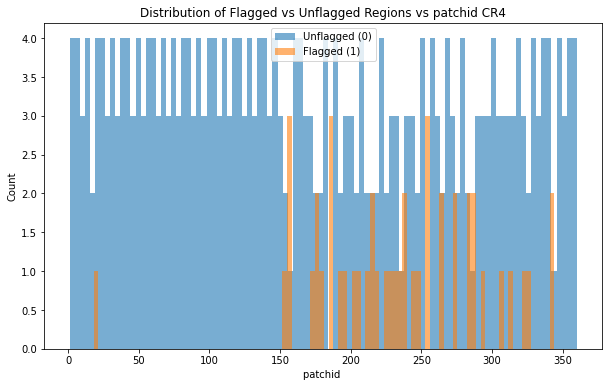

In [669]:

folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[3], "r") as f:
    print(txt_files[3])
    data = [ast.literal_eval(line.strip()) for line in f]

data = np.array(data) 
patchid = data[:, 0]    
flags = data[:, 5]     
phi = data[:, 4] 
lamda=data[:,3]
day=data[:,2]
tipdf=data[:,1]
#print(np.max(tipdf))
#print(np.min(tipdf))


patchid_flagged = patchid [flags == 1]
patchid_unflagged = patchid [flags == 0]
tipdf_flagged = tipdf[flags == 1]
tipdf_unflagged = tipdf[flags == 0]
#print(np.max(tipdf_flagged))
#print(np.min(tipdf_flagged))
#print(np.mean(tipdf_flagged))
#print(np.mean(tipdf_unflagged))


plt.figure(figsize=(10,6))
plt.hist(patchid_unflagged, bins=100, alpha=0.6, label="Unflagged (0)")


plt.hist(patchid_flagged, bins=100, alpha=0.6, label="Flagged (1)")

plt.xlabel("patchid ")
plt.ylabel("Count")
plt.title("Distribution of Flagged vs Unflagged Regions vs patchid CR4")
plt.legend()

image_name= f" CR4(patchid).jpeg"
mag_image= os.path.join(save_dir, image_name)
plt.savefig(mag_image, dpi=300)
plt.show()





In [76]:
#T=header.get("T_OBS")
print(1640+130)

1770


In [646]:
print(11/100)

0.11


In [ ]:
df=pd.read_csv("")

In [670]:
import pandas as pd

In [675]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[3], "r") as f:
    print(txt_files[3])
    data = [ast.literal_eval(line.strip()) for line in f]
df=pd.DataFrame(data, columns=["patchid", "tipdiff", "day", "lamda","phi","flags"])
print(df.head(4))

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR4.txt
   patchid    tipdiff  day  lamda   phi  flags
0       18  21.738616    1   15.0  27.5      1
1      253  19.892036    1  255.0 -22.5      1
2      254  19.892036    1  255.0 -12.5      1
3      255  19.892036    1  255.0  -2.5      1


In [676]:

df.shape



(360, 6)

In [677]:
df.head()

,patchid,tipdiff,day,lamda,phi,flags
0,18,21.738616,1,15.0,27.5,1
1,253,19.892036,1,255.0,-22.5,1
2,254,19.892036,1,255.0,-12.5,1
3,255,19.892036,1,255.0,-2.5,1
4,295,28.024659,1,295.0,-2.5,1


In [678]:
df.sample(5)

,patchid,tipdiff,day,lamda,phi,flags
237,208,33.030081,7,205.0,27.5,0
333,332,36.743749,7,335.0,-32.5,0
236,207,33.030081,7,205.0,17.5,0
223,190,29.477207,7,185.0,47.5,0
107,67,30.843125,7,65.0,17.5,0


In [679]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   patchid  360 non-null    int64  
 1   tipdiff  360 non-null    float64
 2   day      360 non-null    int64  
 3   lamda    360 non-null    float64
 4   phi      360 non-null    float64
 5   flags    360 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 17.0 KB


In [27]:
#cos_lat=np.array(cos_lat)
print(type(cos_lat))
print(type(lon_deg))
print(type(lon_rad))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
#print(sin_lat)
cos_lat[:-1]
cos_lat[1:]

In [ ]:
coslat_avg=np.mean([cos_lat[0:len(coslat)-1],cos_lat[1:]],axis=0)
print(coslat_avg)

In [ ]:
coslat_avg = 0.5 * (cos_lat[:-1] + cos_lat[1:])
print(coslat_avg)
print(cos_lat.shape)

In [ ]:
print(i)
print(j)
sin_lat= -1+i*(2/ny) 
print(sin_lat)

In [ ]:
print(len(output1))

In [ ]:
print((29+44)/2)

In [ ]:
print("hi")

In [ ]:
--NotebookApp.iopub_data_rate_limit


In [952]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(-150*u.arcsec, -151*u.arcsec,
               frame=frames.Helioprojective,
               observer="earth",
               obstime="2014-04-14")


cr = hpc.transform_to(frames.HeliographicCarrington)
print(cr)

<SkyCoord (HeliographicCarrington: obstime=2014-04-14T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, AU)
    (263.02047576, -14.67516224, 0.00465047)>


In [953]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(-150*u.arcsec, -151*u.arcsec,
               frame=frames.Helioprojective,
               observer="earth",
               obstime="2014-04-13")


cr = hpc.transform_to(frames.HeliographicCarrington)
print(cr)

<SkyCoord (HeliographicCarrington: obstime=2014-04-13T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, AU)
    (276.22258815, -14.74735356, 0.00465047)>


In [954]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(-150*u.arcsec, -151*u.arcsec,
               frame=frames.Helioprojective,
               observer="earth",
               obstime="2014-04-12")


cr = hpc.transform_to(frames.HeliographicCarrington)
print(cr)

<SkyCoord (HeliographicCarrington: obstime=2014-04-12T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, AU)
    (289.42390251, -14.81793138, 0.00465047)>


In [955]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(-150*u.arcsec, -151*u.arcsec,
               frame=frames.Helioprojective,
               observer="earth",
               obstime="2014-04-11")


cr = hpc.transform_to(frames.HeliographicCarrington)
print(cr)

<SkyCoord (HeliographicCarrington: obstime=2014-04-11T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, AU)
    (302.62441, -14.88687224, 0.00465047)>


In [956]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(-150*u.arcsec, -151*u.arcsec,
               frame=frames.Helioprojective,
               observer="earth",
               obstime="2014-04-10")


cr = hpc.transform_to(frames.HeliographicCarrington)
print(cr)

<SkyCoord (HeliographicCarrington: obstime=2014-04-10T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, AU)
    (315.82410478, -14.95415229, 0.00465047)>


In [957]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(-150*u.arcsec, -151*u.arcsec,
               frame=frames.Helioprojective,
               observer="earth",
               obstime="2014-04-9")


cr = hpc.transform_to(frames.HeliographicCarrington)
print(cr)

<SkyCoord (HeliographicCarrington: obstime=2014-04-09T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, AU)
    (329.02298383, -15.01974741, 0.00465047)>


In [951]:
print(249.8175772-236.61390719)

13.203670009999996


In [ ]:
28.82415648, 3.51330253, 0.00465047

In [949]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u



cr = SkyCoord(236.61390719*u.deg, -14.52603034*u.deg,
               frame=frames.HeliographicCarrington,
               observer="earth",
               obstime="2014-04-15")
hpc= cr.transform_to(frames.Helioprojective)


print(hpc)

<SkyCoord (Helioprojective: obstime=2014-04-15T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-355.60080845, -155.45042742, 1.49426287e+08)>


In [1026]:
import sunpy.coordinates
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
import astropy.units as u


hpc = SkyCoord(933*u.arcsec, -241*u.arcsec,
               frame=frames.Helioprojective,
               observer="earth",
               obstime="2014-04-18"
               rsun=695700*u.km)


cr = hpc.transform_to(frames.HeliographicCarrington)
print(cr)


SyntaxError: invalid syntax (<ipython-input-1026-9a8ca0c52871>, line 11)

<SkyCoord (HeliographicCarrington: obstime=2014-04-14T08:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, )
    (178.90601098, -12., 1.)>


['/home/vindia/samapti/cycle24(feb-july)/CR2149/hmi.mrdailysynframe_720s.20140407_120000_TAI.data.fits']
27.315525529038606


In [979]:
with open ("output1.txt","a") as input:
    for value in output:
        input.write(f"{value}\n")    

In [1211]:
print(990-130)
print(1250-130)
print()


860
1120



In [ ]:

with open(output_path, "w") as f:

In [1041]:
import astropy.units as u
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
from astropy.time import Time

# Example flare location: N02W10 on 2006-11-15
flare_coord = SkyCoord(8*u.deg, 4*u.deg, frame=frames.HeliographicStonyhurst,
                       obstime=Time("2006-11-14"), observer="earth")

# Convert to Helioprojective (X, Y arcsec)
hpc = flare_coord.transform_to(frames.Helioprojective(observer="earth"))
print(hpc.Tx.to(u.arcsec), hpc.Ty.to(u.arcsec))
print(hpc)


135.222arcsec 17.7093arcsec
<SkyCoord (Helioprojective: obstime=2006-11-14 00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (135.22175095, 17.70933726, 1.47331872e+08)>


In [1048]:
import astropy.units as u
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
from astropy.time import Time

# Example flare location: N02W10 on 2006-11-15
flare_coord = SkyCoord(-8*u.deg, -4*u.deg, frame=frames.HeliographicStonyhurst,
                       obstime=Time("2006-11-14"), observer="earth")

# Convert to Helioprojective (X, Y arcsec)
hpc = flare_coord.transform_to(frames.HeliographicCarrington(observer="earth"))
#print(hpc.Tx.to(u.arcsec), hpc.Ty.to(u.arcsec))
print(hpc)


<SkyCoord (HeliographicCarrington: obstime=2006-11-14 00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, )
    (3.20954864, -4., 1.)>


In [519]:
sc = SkyCoord(0*u.deg, -90*u.deg, 5*u.km,
              obstime="2010/01/01T00:00:00", observer="earth", frame="helioprojectiveradial")
print(sc)

ValueError: Coordinate frame name "helioprojectiveradial" is not a known coordinate frame (['altaz', 'barycentricmeanecliptic', 'barycentrictrueecliptic', 'cirs', 'custombarycentricecliptic', 'fk4', 'fk4noeterms', 'fk5', 'galactic', 'galacticlsr', 'galactocentric', 'gcrs', 'geocentricearthequatorial', 'geocentricmeanecliptic', 'geocentricsolarecliptic', 'geocentrictrueecliptic', 'hcrs', 'heliocentric', 'heliocentricearthecliptic', 'heliocentriceclipticiau76', 'heliocentricinertial', 'heliocentricmeanecliptic', 'heliocentrictrueecliptic', 'heliographic_carrington', 'heliographic_stonyhurst', 'helioprojective', 'icrs', 'itrs', 'lsr', 'lsrd', 'lsrk', 'precessedgeocentric', 'supergalactic', 'teme', 'tete'])

In [1049]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from astropy.time import Time

# Input flare info
flare_time = Time("2006-11-07 04:05")
lat = 4.0 * u.deg     # N04
lon = -89.0 * u.deg   # E89 → negative longitude in Stonyhurst

# Define heliographic Stonyhurst coordinates (Earth observer)
flare_hgs = SkyCoord(lon, lat,
                     frame=frames.HeliographicStonyhurst,
                     obstime=flare_time,
                     observer="earth")

# Convert to Helioprojective (arcsec)
flare_hpc = flare_hgs.transform_to(frames.Helioprojective(observer="earth"))

print("X (arcsec):", flare_hpc.Tx.to(u.arcsec))
print("Y (arcsec):", flare_hpc.Ty.to(u.arcsec))


X (arcsec): -965.497arcsec
Y (arcsec): 66.2759arcsec


In [2]:
from openpyxl import Workbook

results = [10, 20, 30, 40, 50]

wb = Workbook()
ws = wb.active

# Write each result in a new row
for row_index, value in enumerate(results, start=1):
    ws.cell(row=row_index, column=1, value=value)

wb.save("output.xlsx")


In [518]:
from sunpy.coordinates.sun import L0
from astropy.time import Time

t = Time("2014-05-04T00:23:00")  # or the specific time you want
l0 = L0(t,
light_travel_time_correction=True,
nearest_point=True,
aberration_correction=False)
print(l0)
L=l0.deg
print(L)
#print((L-20)%360)


7d53m06.78109824s
7.885216971733087


In [198]:
from astropy.time import Time
import astropy.units as u

def hgs_to_hgc(lon_hgs_deg, lat_hgs_deg, obstime):
    # Carrington reference epoch
    carr_ref = Time("1853-11-09 09:00:00", scale="utc")
    carr_period =25.38* u.day  # Carrington rotation period
    
    # Time difference in days
    t = Time(obstime, scale="utc")
    delta_days = (t - carr_ref).to(u.day).value
    
    # Carrington longitude of the central meridian (as seen from Earth)
    L0 = (360.0 * (delta_days / carr_period.value))   % 360.0
    print(L0)
    
    # Convert Stonyhurst -> Carrington
    lon_hgc = (L0 + lon_hgs_deg)% 360.0
    lat_hgc = lat_hgs_deg
    
    return lon_hgc, lat_hgc, L0

# Example usage:
lon_hgs = -20.0   # 20° west of central meridian (negative in Stonyhurst)
lat_hgs = 10.0
time_obs = "2025-09-09 04:14:00"

lon_hgc, lat_hgc, L0 = hgs_to_hgc(lon_hgs, lat_hgs, time_obs)
print(f"Carrington: lon={lon_hgc:.3f}°, lat={lat_hgc:.3f}°,l0={L0}")


304.1392500656657
Carrington: lon=284.139°, lat=10.000°,l0=304.1392500656657


In [165]:
print(360/25.38)

14.184397163120568


In [200]:
from datetime import datetime
from astropy.time import Time
import astropy.units as u

# Carrington rotation period
carr_period = 25.38 * u.day

# Reference: start of Carrington Rotation 1 (Nov 9, 1853 09:00 UTC)
ref_time = Time("1853-11-09 09:00:00", scale="utc")

# Any date you want
obs_time = Time("2025-09-09 04:14:00", scale="utc")

# Days since reference
delta_days = (obs_time - ref_time).to(u.day).value

# Compute L0
L0 = (360.0 * (delta_days / carr_period.value)) % 360.0

print(f"L0 = {L0:.3f} degrees")


L0 = 304.139 degrees
